## **Gamma Variation Heuristic**

In [1]:
## import essential modules 
%load_ext autoreload
%autoreload 2
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [2]:
import pickle
import seaborn as sns
sns.set()

### **BAS Dataset** 

In [3]:
gridsize = 3
bas = bas_dataset(grid_size= gridsize); 
data_samples = bas.dataset

wts = hebbing_learning(data_samples)


In [4]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = gridsize*gridsize

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

#evaluating J for BAS dataset
J=-5*wts   #np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])

# defining h
h=np.zeros(np.shape(J)[0])

# instantiate the model
model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {gridsize}")

            MODEL : BAS data of gridsize 3
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 0 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  17.77777777777778
Average Bias Strength <|h|>:  0.0
alpha :  0.025
---------------------------------------------


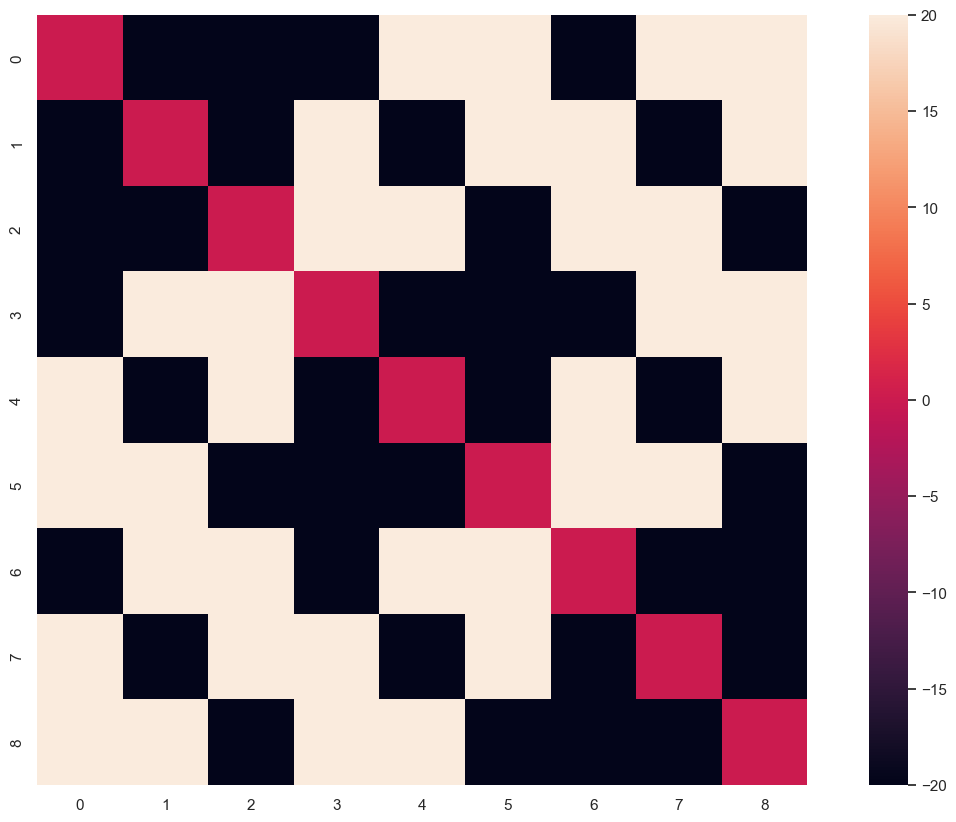

In [5]:
model.model_summary()

     MODEL : BAS data of gridsize 3 |  beta : 1
Num Most Probable States : 12
Entropy : 3.584962500721156
---------------------------------------------


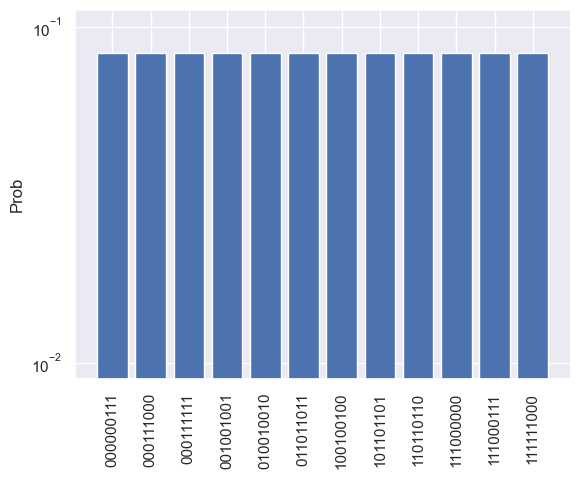

In [6]:
## set current beta
beta = 1#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary(show_threshold=1e-30)
plt.yscale("log")


In [7]:
data_samples

['001001001',
 '010010010',
 '100100100',
 '011011011',
 '101101101',
 '110110110',
 '000000111',
 '000111000',
 '111000000',
 '000111111',
 '111000111',
 '111111000']

In [8]:
from qumcmc.mixers import GenericMixer, CustomMixer, IncoherentMixerSum, CoherentMixerSum

In [9]:
nsteps = 10_000

gamma = 0.5

ws = np.linspace(0, 0.5, 6)

In [ ]:
generic_mixer = GenericMixer.OneBodyMixer(n_spins)
bas_mixer_terms = [[0,3,6],[1,4,7],[2,5,8], [0, 1, 2], [3, 4, 5], [6, 7, 8]]
bas_mixer = CustomMixer(n_spins, bas_mixer_terms)



nreps = 20


all_kls_generic = []
all_kls_coherent = []
all_kls_incoherent = []

for rep in range(nreps):
    initial_state = np.random.choice(data_samples)
    chain = quantum_enhanced_mcmc(
        n_hops=nsteps,
        model=model,
        mixer=generic_mixer,
        gamma = gamma,#(0.9,0.45), # to standardise the problem
        initial_state=initial_state,
        verbose=True
    )
    all_kls_generic.append(calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain))
    

for w in ws:
    print(w)
    kls_coherent = []
    kls_incoherent = []
    
    for rep in range(nreps):
        print(rep)
        initial_state = np.random.choice(data_samples)
        
        coherent_mixer = CoherentMixerSum([generic_mixer, bas_mixer], weights=[1-w, w])

        incoherent_mixer = IncoherentMixerSum([generic_mixer, bas_mixer], probabilities=[1-w, w])

        chain = quantum_enhanced_mcmc(
            n_hops=nsteps,
            model=model,
            mixer=coherent_mixer,
            gamma = gamma,#(0.9,0.45), # to standardise the problem
            initial_state=initial_state,
            verbose=True
        )
        kls_coherent.append(calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain))
        
        chain = quantum_enhanced_mcmc(
            n_hops=nsteps,
            model=model,
            mixer=incoherent_mixer,
            gamma = gamma,#(0.9,0.45), # to standardise the problem
            initial_state=initial_state,
            verbose=True
        )
        kls_incoherent.append(calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain))

    all_kls_coherent.append(kls_coherent)
    all_kls_incoherent.append(kls_incoherent)


chain_generic = quantum_enhanced_mcmc(
                                n_hops=nsteps,
                                model=model,
                                mixer=generic_mixer,
                                gamma = 0.5,#(0.9,0.45), # to standardise the problem
                                initial_state=initial_state,
                                verbose=True
)

starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1008.86it/s]


starting with:  000000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1004.65it/s]


starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1044.54it/s]


starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1036.93it/s]


starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1002.80it/s]


starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1019.20it/s]


starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 991.70it/s]


starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1005.00it/s]


starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1001.41it/s]


starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1014.58it/s]


starting with:  111000000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1025.48it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 681.21it/s]


starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 599.88it/s]


starting with:  001001001 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 601.74it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 599.35it/s]


starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 602.38it/s]


starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 697.67it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 692.70it/s]


starting with:  000000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:12<00:00, 796.29it/s]


starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 907.24it/s]


0.0
20
starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 850.77it/s]


starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 934.15it/s]


20
starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:20<00:00, 497.12it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 577.37it/s]


20
starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:15<00:00, 648.93it/s]


starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 675.38it/s]


20
starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 863.84it/s]


starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 996.61it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 868.35it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:15<00:00, 645.04it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 517.69it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 577.40it/s]


20
starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 514.39it/s]


starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 579.71it/s]


20
starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 679.68it/s]


starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 582.11it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 505.76it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 574.77it/s]


20
starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 512.63it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 573.01it/s]


20
starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 506.65it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 568.37it/s]


20
starting with:  001001001 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 509.72it/s]


starting with:  001001001 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 576.74it/s]


20
starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 511.91it/s]


starting with:  000111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 707.36it/s]


20
starting with:  001001001 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 686.25it/s]


starting with:  001001001 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:17<00:00, 583.96it/s]


20
starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:19<00:00, 505.44it/s]


starting with:  010010010 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:12<00:00, 772.63it/s]


20
starting with:  011011011 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 592.12it/s]


starting with:  011011011 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:16<00:00, 621.36it/s]


20
starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 873.28it/s]


starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 997.93it/s]


20
starting with:  011011011 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 879.13it/s]


starting with:  011011011 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 996.60it/s]


20
starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 889.11it/s]


starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 988.24it/s]


20
starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:12<00:00, 779.53it/s]


starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 964.50it/s]


0.1
20
starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:14<00:00, 682.10it/s]


starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 997.81it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 870.81it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 997.71it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 854.78it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 971.02it/s]


20
starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 879.56it/s]


starting with:  101101101 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|█| 10000/10000 [00:09<00:00, 1002.83it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 881.68it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 987.36it/s]


20
starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 857.74it/s]


starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 998.40it/s]


20
starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 874.95it/s]


starting with:  110110110 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 986.05it/s]


20
starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:12<00:00, 825.07it/s]


starting with:  111111000 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 967.32it/s]


20
starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 857.12it/s]


starting with:  111000111 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 990.64it/s]


20
starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:11<00:00, 855.04it/s]


starting with:  100100100 with energy: -240.0


runnning quantum MCMC steps . ..: 100%|██| 10000/10000 [00:10<00:00, 966.85it/s]


20
starting with:  000111111 with energy: -240.0


runnning quantum MCMC steps . ..:  81%|██▍| 8119/10000 [00:13<00:03, 522.26it/s]

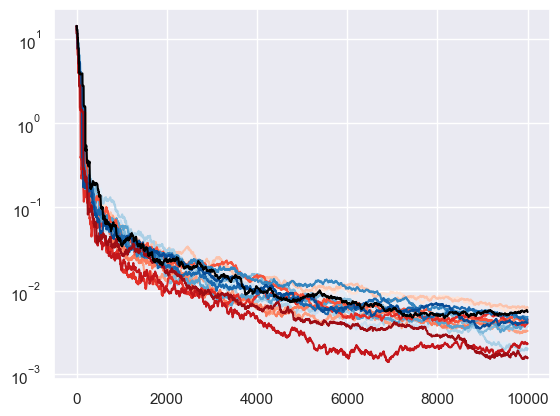

In [18]:
for ii, w in enumerate(ws):
    if ii > len(all_kls_coherent)-1:
        continue
    plt.plot(np.median(all_kls_coherent[ii], axis=0), color=plt.get_cmap("Blues", 10)(ii+1), label=f"{w}")
    plt.plot(np.median(all_kls_incoherent[ii], axis=0), color=plt.get_cmap("Reds", 10)(ii+1), label=f"{w}")
    
plt.plot(np.median(all_kls_generic, axis=0), color="black")

plt.yscale("log")

#### **DECOY MODEL**

In [10]:
h

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

            MODEL : zero-interaction-model
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 0 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  13.333333333333334
Average Bias Strength <|h|>:  0.0
alpha :  0.028867513459481287
---------------------------------------------


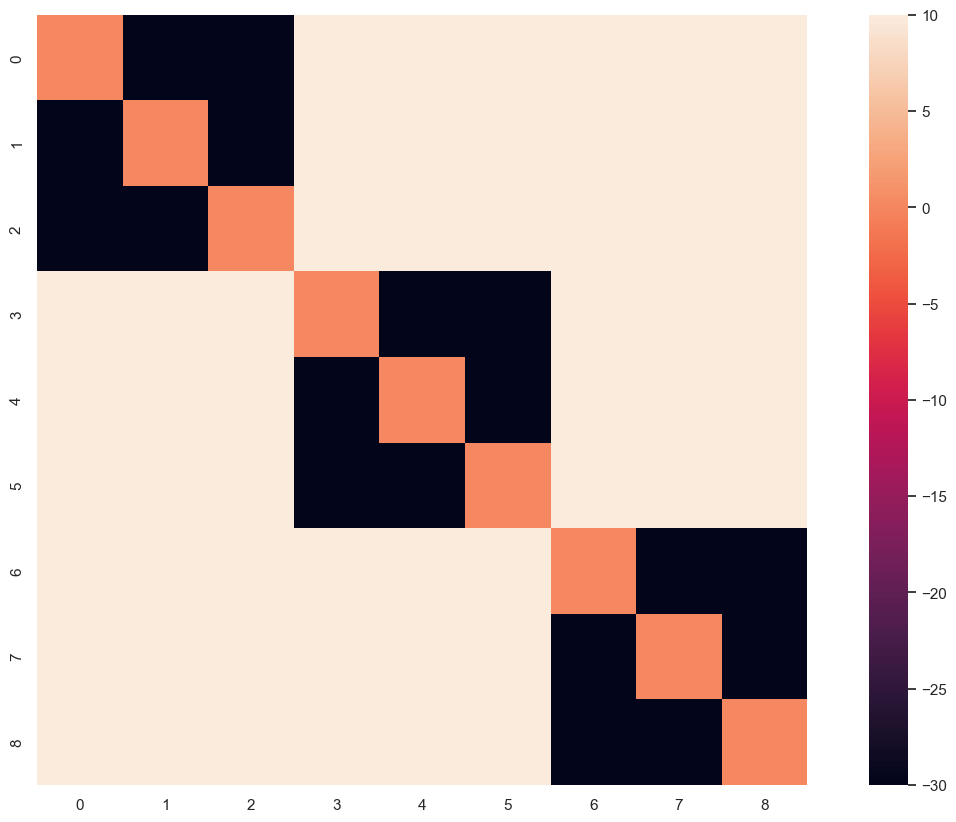

In [11]:
###
J_zero = np.zeros((n_spins, n_spins))

model_zero = IsingEnergyFunction(J, h, name= 'zero-interaction-model', circuit_J=J_zero)

model_zero.model_summary();
model_zero_exact = Exact_Sampling(model_zero, beta);


            MODEL : zero-interaction-model
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 0 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  13.333333333333334
Average Bias Strength <|h|>:  0.0
alpha :  0.028867513459481287
---------------------------------------------


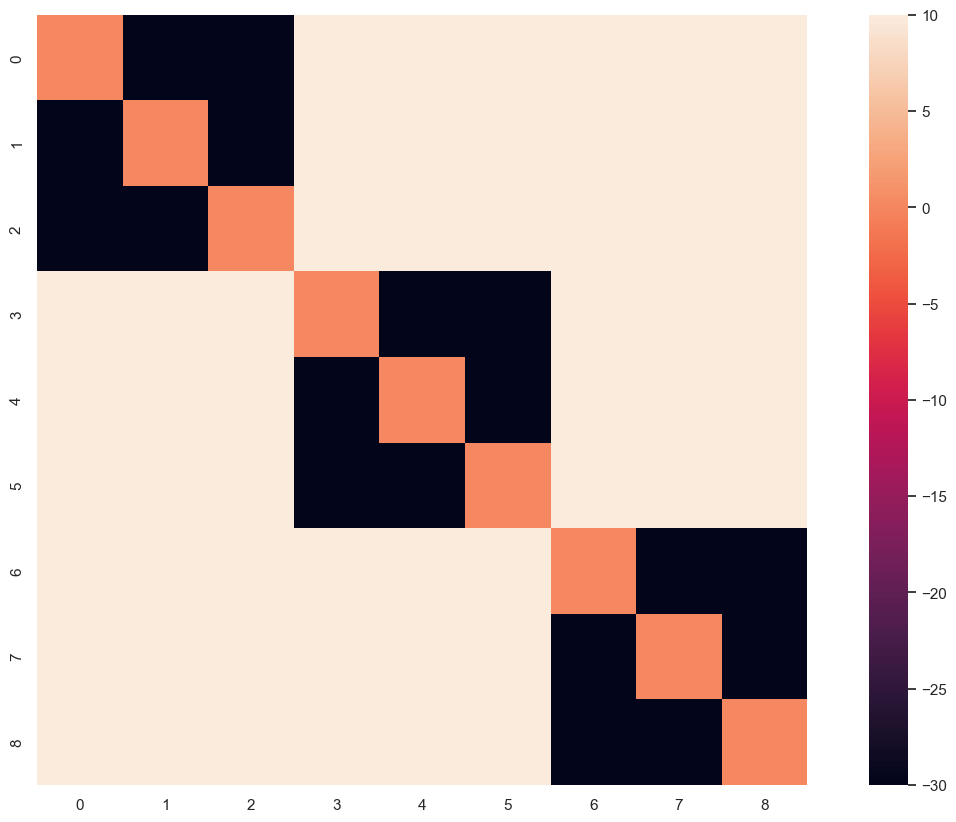

In [12]:
###
np.random.seed(42)

J_miss = J + np.random.randn(*J.shape)*8

model_miss = IsingEnergyFunction(J, h, name= 'zero-interaction-model', circuit_J=J_miss)

model_miss.model_summary();
model_miss_exact = Exact_Sampling(model_miss, beta);


In [13]:
# model = model_zero; exact_sampled_model = model_zero_exact

#### **quMCMC for gamma variation**

In [11]:
initial_state = bas.dataset[0]
steps= 10000

In [12]:
qmcmc_bmix_pertgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_pertgamma', gamma_range= (0.001, 0.1)
)

NameError: name 'quantum_enhanced_mcmc' is not defined

In [ ]:
qmcmc_bmix_lowgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_lowgamma', gamma_range=(0.1,0.25)
)

In [17]:
qmcmc_bmix_medgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_medgamma', gamma_range=(0.3,0.65)
)

In [18]:
qmcmc_bmix_higamm = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_higamma', gamma_range=(0.75, 1.00)
)

In [19]:
qmcmc_bmix_lowgamma.states

[MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='1010', accepted=True),
 MCMCState(bitstring='0110', accepted=False),
 MCMCState(bitstring='1010', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCStat

In [32]:
## Perturbative Gamma range : (0.001 -> 0.09)
qmcmc_advmix_pertgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.001, 0.09),
    # single_qubit_mixer= False, 
    pauli_index_list= [1]*gridsize,
    name= 'advmix_pertgamma'
)

TypeError: quantum_enhanced_mcmc() got an unexpected keyword argument 'pauli_index_list'

In [ ]:
## Low Gamma range : (0.1 -> 0.25)
qmcmc_advmix_lowgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.1, 0.25),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmic_lowgamma'
)

In [18]:
## Medium Gamma range : (0.25 -> 0.75)
qmcmc_advmix_medgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.25, 0.75),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_medgamma'
)

In [19]:
## High Gamma range : (0.75 -> 0.9)
qmcmc_advmix_higamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.75, 0.9),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_higamma'
)

In [20]:
## Extreme Gamma range : (0.9 -> 0.9999)
qmcmc_advmix_extgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.9, 0.9999),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_extgamma'
)

In [21]:
## Extra trial ##

qmcmc_extra = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.5,0.6),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_extra'
)

#### **Analysis**

In [23]:
qchains = [qmcmc_bmix_pertgamma, qmcmc_bmix_lowgamma, qmcmc_bmix_medgamma, qmcmc_bmix_higamm] #, qmcmc_advmix_pertgamma, qmcmc_advmix_lowgamma, qmcmc_advmix_medgamma, qmcmc_advmix_higamma, qmcmc_advmix_extgamma, qmcmc_extra]


# with open('SavedData/GammaVaraitionData/gv_qchains_v0.pickle', 'wb') as f:

#     pickle.dump( qchains ,f)


In [24]:
# with open('SavedData/GammaVaraitionData/gv_qchains_v0.pickle', 'rb') as f:

#     qchains = pickle.load(f)

In [25]:
kldivs = {}
for chain in qchains: kldivs[chain.name] = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain)

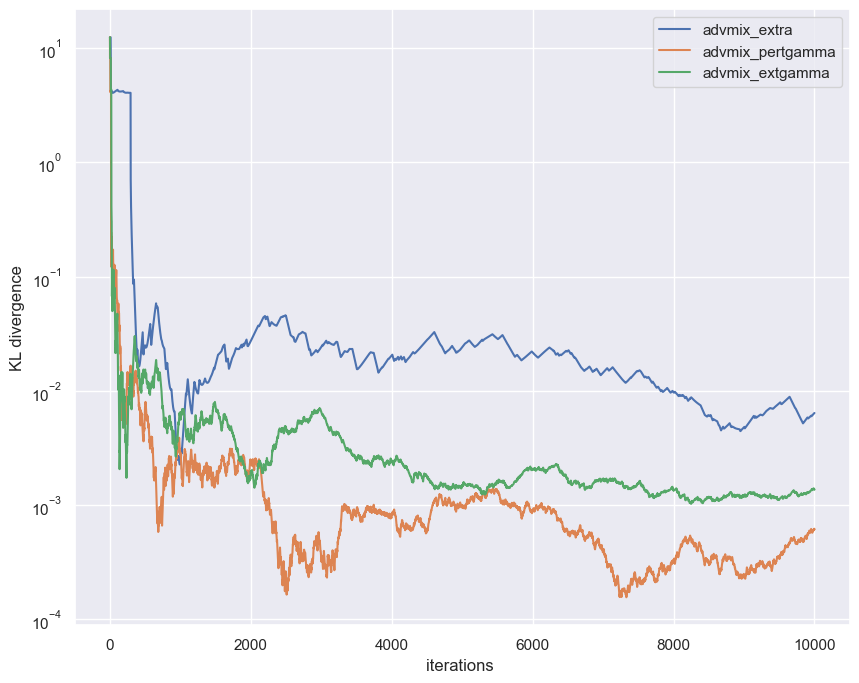

In [26]:
plt.figure(figsize=(10,8))

plt.plot(kldivs['basic_mixer_lowgamma'], label='advmix_extra')
plt.plot(kldivs['basic_mixer_medgamma'], label='advmix_pertgamma')
plt.plot(kldivs['basic_mixer_higamma'], label='advmix_extgamma')

plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
# plt.xscale("log")
plt.legend()
plt.show()

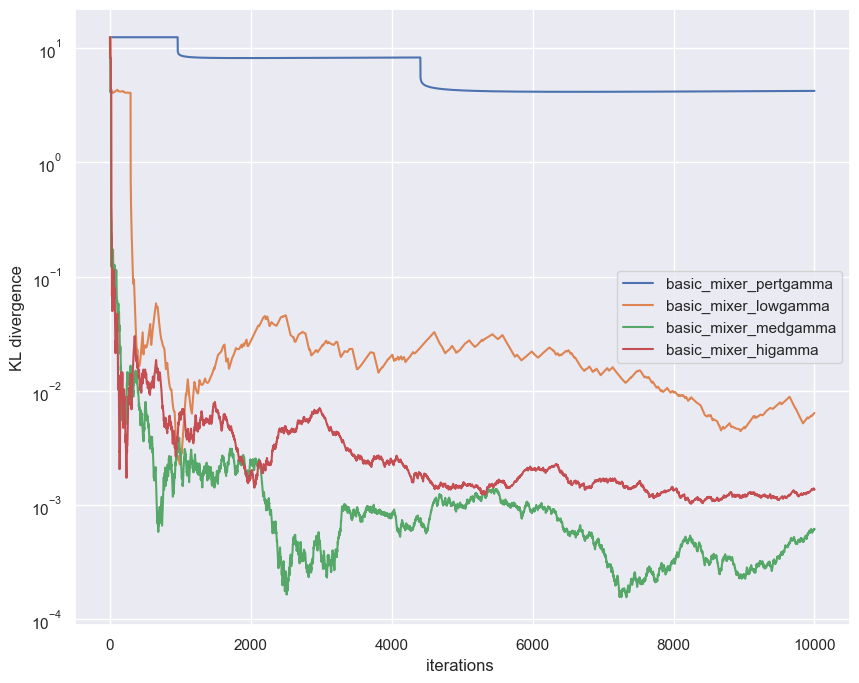

In [27]:
plt.figure(figsize=(10,8))

for items in list(kldivs.items()):
    plt.plot(items[1], label= items[0])

plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
# plt.xscale("log")
plt.legend()
plt.show()

In [82]:
trajectory_stat = {}
for chain in qchains : 
    trajectory_stat[chain.name]  = get_trajectory_statistics(chain, exact_sampled_model)


ValueError: shapes (9,9) and (4,) not aligned: 9 (dim 1) != 4 (dim 0)

TypeError: object of type 'int' has no len()

## Mixers

In [14]:
initial_state = data_samples[0]
initial_state

'000000111'

In [15]:
steps = 50_00

In [68]:
from qumcmc.mixers import GenericMixer, CustomMixer, CoherentMixerSum, IncoherentMixerSum

In [96]:
generic_mixer = GenericMixer.OneBodyMixer(n_spins)

In [97]:
res = quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    mixer=generic_mixer,
    gamma=0.5,
    initial_state=initial_state,
    temperature=1/beta,
    name= 'basic_lowgamma',
    verbose=True
)


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|███| 5000/5000 [00:04<00:00, 1002.31it/s]


In [98]:
get_trajectory_statistics(res, exact_sampled_model)

{'acceptance_prob': array([0.5       , 0.16666667, 0.25      , ..., 0.33333333, 0.5       ,
        0.5       ]),
 'energy': array([  0., 320., 240., ..., 120.,   0., 120.]),
 'hamming': {0: {'accepted': 554, 'rejected': 0, 'total': 554},
  1: {'accepted': 0, 'rejected': 445, 'total': 445},
  2: {'accepted': 0, 'rejected': 812, 'total': 812},
  3: {'accepted': 838, 'rejected': 456, 'total': 1294},
  4: {'accepted': 0, 'rejected': 586, 'total': 586},
  5: {'accepted': 0, 'rejected': 327, 'total': 327},
  6: {'accepted': 229, 'rejected': 154, 'total': 383},
  7: {'accepted': 0, 'rejected': 245, 'total': 245},
  8: {'accepted': 0, 'rejected': 155, 'total': 155},
  9: {'accepted': 199, 'rejected': 0, 'total': 199}},
 'kldiv': array([1.35588078e+01, 1.07197434e+01, 1.07393739e+01, ...,
        6.22215167e-03, 6.25424555e-03, 6.28646845e-03])}

In [80]:
custom_mixer = CustomMixer(n_spins, [[0, 1, 2], [3, 4, 5], [6, 7, 8]])

In [81]:
res = quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    mixer=custom_mixer,
    gamma = 0.5, 
    initial_state=initial_state,
    temperature=1/beta,
    name= 'basic_lowgamma',
    verbose=True
)


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|███| 5000/5000 [00:04<00:00, 1159.52it/s]


In [82]:
get_trajectory_statistics(res, exact_sampled_model)

{'acceptance_prob': array([0.33333333, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]),
 'energy': array([0., 0., 0., ..., 0., 0., 0.]),
 'hamming': {0: {'accepted': 1026, 'rejected': 0, 'total': 1026},
  1: {'accepted': 0, 'rejected': 0, 'total': 0},
  2: {'accepted': 0, 'rejected': 0, 'total': 0},
  3: {'accepted': 1201, 'rejected': 285, 'total': 1486},
  4: {'accepted': 0, 'rejected': 0, 'total': 0},
  5: {'accepted': 0, 'rejected': 0, 'total': 0},
  6: {'accepted': 859, 'rejected': 174, 'total': 1033},
  7: {'accepted': 0, 'rejected': 0, 'total': 0},
  8: {'accepted': 0, 'rejected': 0, 'total': 0},
  9: {'accepted': 1455, 'rejected': 0, 'total': 1455}},
 'kldiv': array([1.35588078e+01, 1.35588078e+01, 1.07393739e+01, ...,
        4.19070758e-04, 4.19609388e-04, 4.27022452e-04])}

In [106]:
coherent_mixer = CoherentMixerSum([generic_mixer, CustomMixer(n_spins, [[0, 1, 2], [3, 4, 5]])], weights=[0.5, 0.5]) # partial knowledge

In [107]:
res = quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    mixer=coherent_mixer,
    gamma = 0.5, 
    initial_state=initial_state,
    temperature=1/beta,
    name= 'basic_lowgamma',
    verbose=True
)


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|████| 5000/5000 [00:05<00:00, 958.72it/s]


In [108]:
get_trajectory_statistics(res, exact_sampled_model)

{'acceptance_prob': array([0.33333333, 1.        , 0.25      , ..., 0.09090909, 1.        ,
        1.        ]),
 'energy': array([240.,   0.,   0., ..., 120.,   0.,   0.]),
 'hamming': {0: {'accepted': 1041, 'rejected': 0, 'total': 1041},
  1: {'accepted': 0, 'rejected': 484, 'total': 484},
  2: {'accepted': 0, 'rejected': 481, 'total': 481},
  3: {'accepted': 1000, 'rejected': 141, 'total': 1141},
  4: {'accepted': 0, 'rejected': 210, 'total': 210},
  5: {'accepted': 0, 'rejected': 211, 'total': 211},
  6: {'accepted': 1153, 'rejected': 66, 'total': 1219},
  7: {'accepted': 0, 'rejected': 141, 'total': 141},
  8: {'accepted': 0, 'rejected': 28, 'total': 28},
  9: {'accepted': 44, 'rejected': 0, 'total': 44}},
 'kldiv': array([1.35588078e+01, 1.35588078e+01, 1.07393739e+01, ...,
        1.49627089e-03, 1.48572022e-03, 1.47645140e-03])}

In [100]:
incoherent_mixer = IncoherentMixerSum([generic_mixer, CustomMixer(n_spins, [[0, 1, 2], [3, 4, 5]])], probabilities=[0.5, 0.5]) # patial knowledge

In [101]:
res = quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    mixer=incoherent_mixer,
    gamma = 0.5, 
    initial_state=initial_state,
    temperature=1/beta,
    name= 'basic_lowgamma',
    verbose=True
)


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|███| 5000/5000 [00:04<00:00, 1037.95it/s]


In [102]:
get_trajectory_statistics(res, exact_sampled_model)

{'acceptance_prob': array([0.33333333, 1.        , 0.5       , ..., 1.        , 0.25      ,
        1.        ]),
 'energy': array([240.,   0.,   0., ..., 120., 400.,   0.]),
 'hamming': {0: {'accepted': 1330, 'rejected': 0, 'total': 1330},
  1: {'accepted': 0, 'rejected': 184, 'total': 184},
  2: {'accepted': 0, 'rejected': 437, 'total': 437},
  3: {'accepted': 1106, 'rejected': 339, 'total': 1445},
  4: {'accepted': 0, 'rejected': 310, 'total': 310},
  5: {'accepted': 0, 'rejected': 165, 'total': 165},
  6: {'accepted': 725, 'rejected': 129, 'total': 854},
  7: {'accepted': 0, 'rejected': 106, 'total': 106},
  8: {'accepted': 0, 'rejected': 79, 'total': 79},
  9: {'accepted': 90, 'rejected': 0, 'total': 90}},
 'kldiv': array([1.35588078e+01, 1.35588078e+01, 1.07393739e+01, ...,
        1.55399560e-03, 1.55162740e-03, 1.56145716e-03])}

In [220]:
initial_state = data_samples[0]
initial_state

'000000111'

In [231]:
steps = 50_000

In [232]:
res = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.35,0.35),
    name= 'basic_lowgamma',
    verbose=True
)


res_miss = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model_miss,
    temperature=1/beta,
    gamma_range= (0.35, 0.35),
    name= 'basic_lowgamma_miss',
    verbose=True
)

res_zero = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model_zero,
    temperature=1/beta,
    gamma_range= (0.05, 0.05),
    name= 'basic_lowgamma_zero',
    verbose=True
)



starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|██| 50000/50000 [02:07<00:00, 391.57it/s]


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|██| 50000/50000 [02:06<00:00, 394.85it/s]


starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|██| 50000/50000 [02:35<00:00, 321.01it/s]


In [233]:
r = get_trajectory_statistics(res, exact_sampled_model)
hams = r["hamming"]
hams

{0: {'accepted': 26338, 'rejected': 0, 'total': 26338},
 1: {'accepted': 0, 'rejected': 10323, 'total': 10323},
 2: {'accepted': 0, 'rejected': 5566, 'total': 5566},
 3: {'accepted': 3862, 'rejected': 1017, 'total': 4879},
 4: {'accepted': 0, 'rejected': 1521, 'total': 1521},
 5: {'accepted': 0, 'rejected': 687, 'total': 687},
 6: {'accepted': 122, 'rejected': 314, 'total': 436},
 7: {'accepted': 0, 'rejected': 198, 'total': 198},
 8: {'accepted': 0, 'rejected': 48, 'total': 48},
 9: {'accepted': 3, 'rejected': 0, 'total': 3}}

In [234]:
rm = get_trajectory_statistics(res_miss, model_miss_exact)
hams_miss = rm["hamming"]
hams_miss

{0: {'accepted': 20406, 'rejected': 0, 'total': 20406},
 1: {'accepted': 0, 'rejected': 12962, 'total': 12962},
 2: {'accepted': 0, 'rejected': 7540, 'total': 7540},
 3: {'accepted': 3894, 'rejected': 2070, 'total': 5964},
 4: {'accepted': 0, 'rejected': 1780, 'total': 1780},
 5: {'accepted': 0, 'rejected': 782, 'total': 782},
 6: {'accepted': 40, 'rejected': 356, 'total': 396},
 7: {'accepted': 0, 'rejected': 135, 'total': 135},
 8: {'accepted': 0, 'rejected': 31, 'total': 31},
 9: {'accepted': 3, 'rejected': 0, 'total': 3}}

In [235]:
rz = get_trajectory_statistics(res_zero, model_zero_exact)
hams_zero = rz["hamming"]
hams_zero

{0: {'accepted': 23018, 'rejected': 0, 'total': 23018},
 1: {'accepted': 0, 'rejected': 13415, 'total': 13415},
 2: {'accepted': 0, 'rejected': 7810, 'total': 7810},
 3: {'accepted': 100, 'rejected': 3749, 'total': 3849},
 4: {'accepted': 0, 'rejected': 1471, 'total': 1471},
 5: {'accepted': 0, 'rejected': 362, 'total': 362},
 6: {'accepted': 3, 'rejected': 64, 'total': 67},
 7: {'accepted': 0, 'rejected': 7, 'total': 7},
 8: {'accepted': 0, 'rejected': 1, 'total': 1},
 9: {'accepted': 0, 'rejected': 0, 'total': 0}}

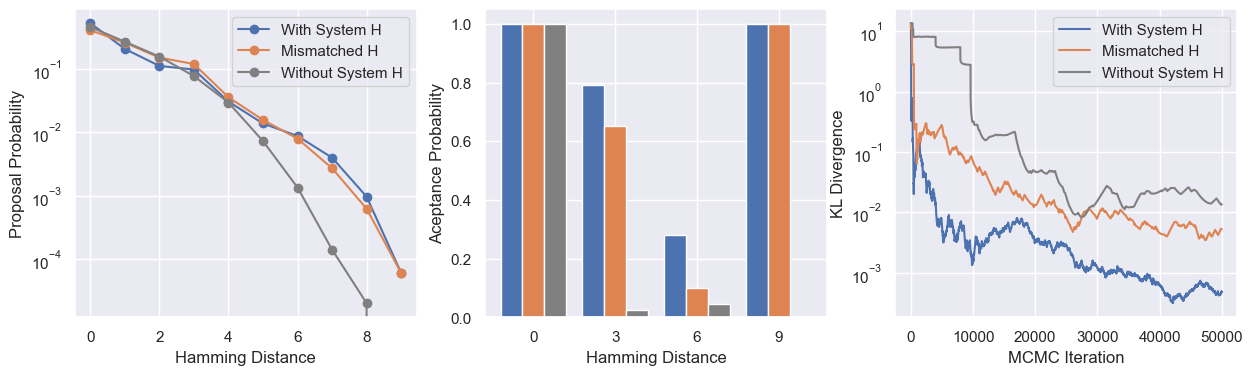

In [241]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
(ax1, ax2, ax3) = axes

ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in r["hamming"].values()], marker="o", label="With System H")
ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rm["hamming"].values()], marker="o", label="Mismatched H")
ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rz["hamming"].values()], marker="o", label="Without System H", color="grey")
ax1.set_yscale("log")
ax1.set_ylabel("Proposal Probability")
ax1.set_xlabel("Hamming Distance")
ax1.legend()

ax2.bar(np.arange(gridsize**2+1)-0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in r["hamming"].values() ], label="With System H")
ax2.bar(np.arange(gridsize**2+1)-0.0, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in rm["hamming"].values() ], label="Mismatched H")
ax2.bar(np.arange(gridsize**2+1)+0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in rz["hamming"].values() ], label="Without System H", color="grey")
# plt.yscale("log")
ax2.set_ylabel("Aceptance Probability")
ax2.set_xlabel("Hamming Distance")
ax2.set_xticks([0, 3, 6, 9])
# ax2.legend()

ax3.plot(r["kldiv"], label="With System H")
ax3.plot(rm["kldiv"], label="Mismatched H")
ax3.plot(rz["kldiv"], label="Without System H", color="grey")
plt.yscale("log")
ax3.set_ylabel("KL Divergence")
ax3.set_xlabel("MCMC Iteration")
ax3.legend(loc="upper right")

In [112]:
from typing import Union

isinstance(1, Union[float, int])

True

In [1]:
model

NameError: name 'model' is not defined

In [116]:
generic_mixer = GenericMixer.OneBodyMixer(n_spins)
custom_mixer_stripes = CustomMixer(n_spins,[[0,3,6],[1,4,7],[2,5,8]])
custom_mixer_bars =  CustomMixer(n_spins,[[0, 1, 2], [3, 4, 5], [6, 7, 8]] )

coherent_mixer_only_bars = CoherentMixerSum([generic_mixer, custom_mixer_bars], 
                                            weights=[0.75, 0.25])
coherent_mixer_with_BAS_info = CoherentMixerSum([generic_mixer, custom_mixer_bars, custom_mixer_stripes],
                                                weights=[0.7,0.15,0.15])


incoherent_mixer_only_bars = IncoherentMixerSum([generic_mixer, custom_mixer_bars],
                                                probabilities=[0.75, 0.25])
incoherent_mixer_with_BAS_info = IncoherentMixerSum([generic_mixer, custom_mixer_bars, 
                                                    custom_mixer_stripes],
                                                probabilities=[0.7,0.15,0.15])


mcmc_std = quantum_enhanced_mcmc(
                                    n_hops=steps,
                                    model=model,
                                    mixer=incoherent_mixer_with_BAS_info,
                                    gamma = 0.5,#(0.9,0.45), # to standardise the problem
                                    initial_state=initial_state,
                                    temperature=1/beta, 
                                    verbose=True
                                )

starting with:  000000111 with energy: -360.0


runnning quantum MCMC steps . ..: 100%|███| 5000/5000 [00:04<00:00, 1015.71it/s]


array([13.55880782, 13.55880782, 13.55880782, ...,  0.03261017,
        0.03266633,  0.03272257])

In [98]:
hamming_diff = lambda si, sf: hamming_dist(si.bitstring, sf.bitstring)

In [119]:
indataset = 0
tot = 0
trajectory = res_zero.states

current_bs_idx=0
for proposed_bs_idx in range(1,len(trajectory)):
    hamming_dist_val=hamming_diff(si=trajectory[current_bs_idx],
                                    sf=trajectory[proposed_bs_idx])
    if trajectory[proposed_bs_idx].accepted:
        # dict_hamming_distance_statistics[hamming_dist_val]['accepted']+=1
        current_bs_idx=proposed_bs_idx
    else:
        # dict_hamming_distance_statistics[hamming_dist_val]['rejected']+=1
        pass
    
    if hamming_dist_val == 3:
        indataset += trajectory[proposed_bs_idx].accepted
        tot += 1
        
    
indataset 

6

In [120]:
indataset, tot

(6, 351)

In [101]:
this_bs

MCMCState(bitstring='001001001', accepted=True)

In [35]:
current_bs_idx=0
for proposed_bs_idx in range(1,len(trajectory)):
    hamming_dist_val=hamming_diff(si=trajectory[current_bs_idx],
                                    sf=trajectory[proposed_bs_idx])
    if trajectory[proposed_bs_idx].accepted:
        dict_hamming_distance_statistics[hamming_dist_val]['accepted']+=1
        current_bs_idx=proposed_bs_idx
    else:
        dict_hamming_distance_statistics[hamming_dist_val]['rejected']+=1

NameError: name 'trajectory' is not defined

(array([0.0000e+00, 1.3000e+01, 2.4700e+02, 5.5700e+02, 1.7580e+03,
        2.0060e+03, 0.0000e+00, 3.4200e+03, 0.0000e+00, 6.0150e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0556e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8407e+04]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <BarContainer object of 29 artists>)

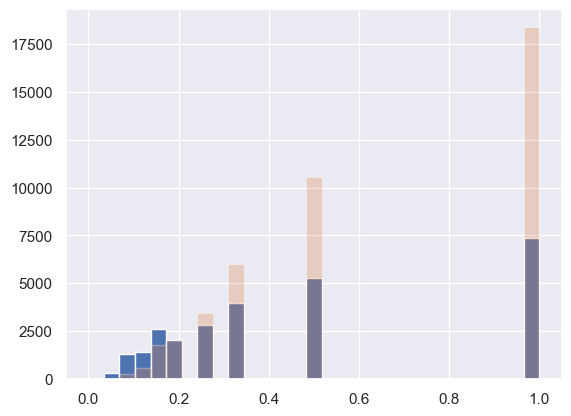

In [123]:
plt.hist(r["acceptance_prob"], bins=np.linspace(0, 1, 30))
plt.hist(rz["acceptance_prob"], bins=np.linspace(0, 1, 30), alpha=0.3)

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

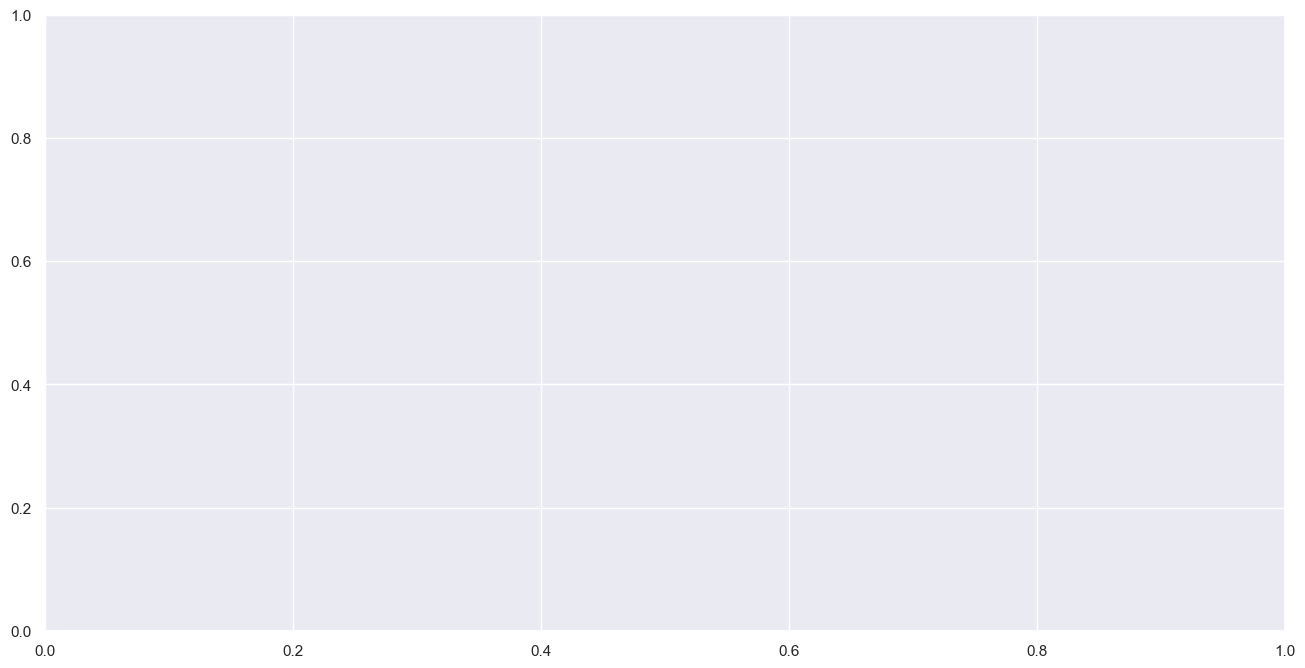

In [30]:
plot_hamming_distance_statistics(list(trajectory_stat.values()), nspin= n_spins,labels= list(trajectory_stat.keys()))

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

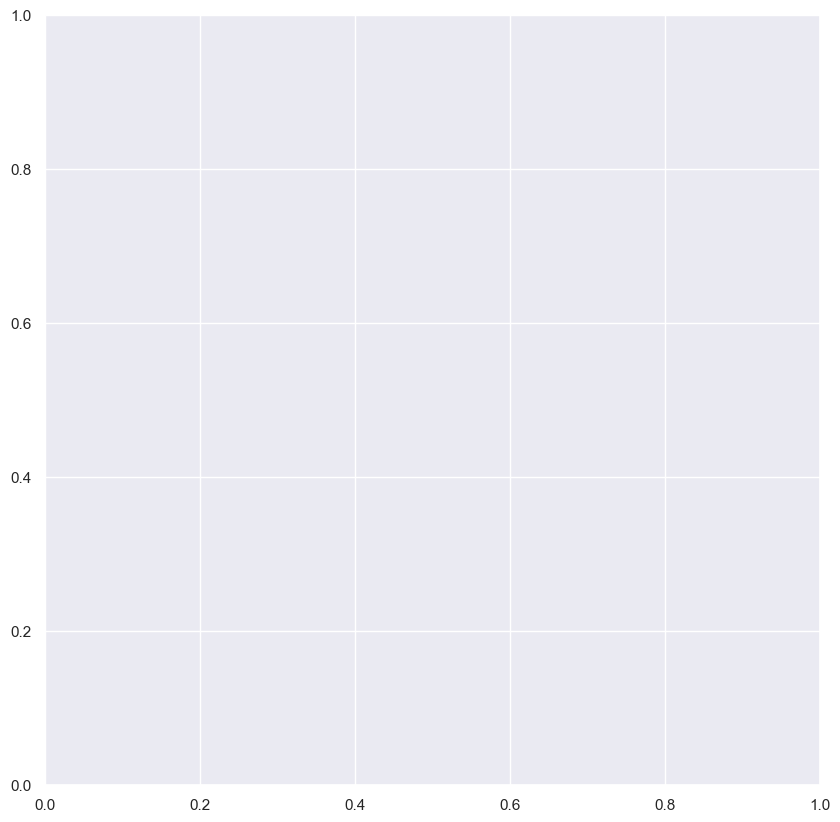

In [31]:
plt.figure(figsize=(10,10))

bins = np.arange(0, n_spins+1)

for item in list(trajectory_stat.items())[:4]:

    plt.bar(*np.unique(item[1]['hamming'], return_counts=True),label= item[0] ,alpha= 0.3)

# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [32]:
plt.figure(figsize=(10,10))

bins = np.linspace(np.log10(np.min([np.min(trajectory_stat['advmic_lowgamma']['acceptance_prob']),
                                    np.min(trajectory_stat['advmix_extra']['acceptance_prob']),
                                    np.min(trajectory_stat['advmix_extgamma']['acceptance_prob'])]))-0.1, 0, num=30)

plt.hist(np.log10(trajectory_stat['advmic_lowgamma']['acceptance_prob']),label= 'advmic_lowgamma' , alpha= 0.8, bins= bins, density=True)
plt.hist(np.log10(trajectory_stat['advmix_extra']['acceptance_prob']),label= 'advmix_extra' , alpha= 0.6, bins= bins, density=True)
plt.hist(np.log10(trajectory_stat['advmix_higamma']['acceptance_prob']),label= 'advmix_higamma' ,alpha= 0.4, bins= bins, density=True)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

KeyError: 'advmic_lowgamma'

<Figure size 1000x1000 with 0 Axes>

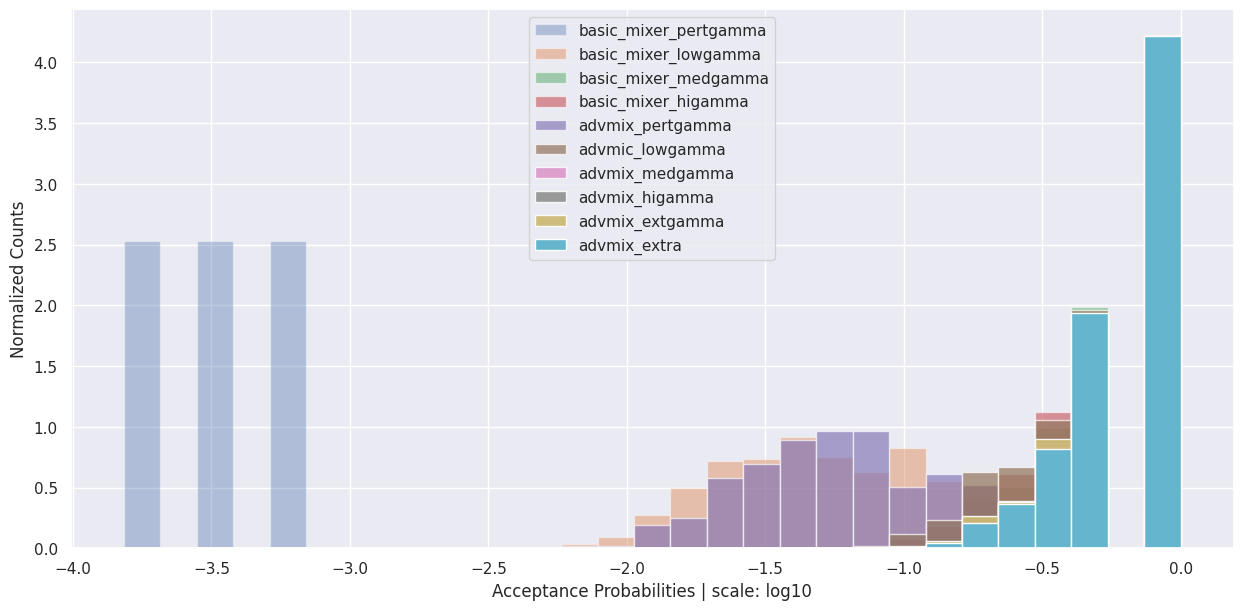

In [13]:
plot_acceptance_prob_statistics(list(trajectory_stat.values()), labels= list(trajectory_stat.keys()))

## ORQVIZ

In [14]:
import orqviz
import matplotlib.pyplot as plt

In [15]:
from typing import Callable, Optional, Tuple

import numpy as np

from orqviz.aliases import (
    ArrayOfParameterVectors,
    FullGradientFunction,
    LossFunction,
    ParameterVector,
)
from orqviz.gradients import calculate_full_gradient


def gradient_descent_optimizer(
    init_params: ParameterVector,
    loss_function: LossFunction,
    n_iters: int,
    learning_rate: float = 0.1,
    full_gradient_function: FullGradientFunction = None,
    eval_loss_during_training: bool = True,
) -> Tuple[ArrayOfParameterVectors, np.ndarray]:
    """Function perform gradient descent optimization on a loss function.

    Args:
        init_params: Initial parameter vector from which to start the optimization.
        loss_function: Function with respect to which the gradient is calculated.
            It must receive only a numpy.ndarray of parameters, and return
            a real number. If your function requires more arguments, consider using the
            'LossFunctionWrapper' class from 'orqviz.loss_function'.
        n_iters: Number of iterations to optimize.
        learning_rate: Learning rate for gradient descent. The calculated gradient
            is multiplied with this value and then updates the parameter vector.
        full_gradient_function: Gradient function to calculate the partial derivatives
            of the loss function with respect to each parameter vector entry.
            If None, a simple numerical gradient is computed. Defaults to None.
        eval_loss_during_training: Flag to indicate whether to evaluate the loss
            at every iteration during training. Doing so adds 'n_iters-1'
            loss function calls. If False, only the initial and final losses
            are calculated and returned. Defaults to False.
    """
    if full_gradient_function is None:

        def _full_gradient_function(params):
            return calculate_full_gradient(params, loss_function=loss_function)

        full_gradient_function = _full_gradient_function

    params = init_params
    all_costs = []
    all_params = [init_params]
    for _ in range(n_iters):
        if eval_loss_during_training:
            all_costs.append(loss_function(params))
        grad_val = full_gradient_function(params)
        params = params - learning_rate * grad_val
        all_params.append(params)

    all_costs.append(loss_function(params))

    return np.array(all_params), np.array(all_costs)

In [90]:
def loss_function(x):
    global params_shape
    assert (x.shape == np.atleast_1d(params_shape)).all()
    return np.sum(np.cos(x * x[::-1]))**2 / np.prod(params_shape)

In [91]:
params_shape = 10

np.random.seed(42)

params1 = np.random.randn(params_shape)

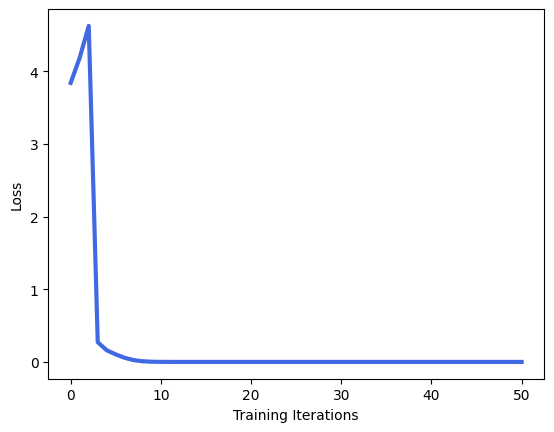

In [106]:
gradient_function = lambda pars: calculate_full_gradient(pars, loss_function, eps=1e-5, stochastic=False)

parameter_trajectory, costs = gradient_descent_optimizer(init_params=params1, loss_function=loss_function, 
                                                         n_iters=50, learning_rate=2e-1,
                                                         full_gradient_function=gradient_function)
    
final_params = parameter_trajectory[-1]
plt.plot(costs, color="royalblue", linewidth=3)
plt.ylabel("Loss")
plt.xlabel("Training Iterations")
plt.show()

In [107]:
from orqviz.pca import get_pca, perform_2D_pca_scan, plot_pca_landscape, plot_optimization_trajectory_on_pca, plot_scatter_points_on_pca

In [109]:
pca = get_pca(parameter_trajectory, components_ids=(0,1))
pca_scan_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=200, offset=1)

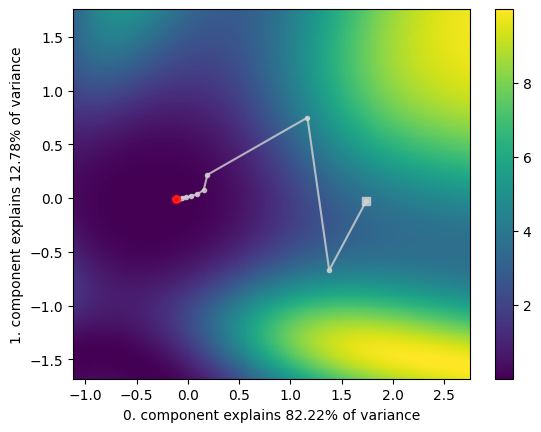

In [116]:
fig, ax = plt.subplots(1,1)


plot_pca_landscape(pca_scan_result, pca, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory, pca, ax=ax)
plot_scatter_points_on_pca([final_params], pca, color="red", zorder=3, linewidth=4, ax=ax)
plt.show()